# Loading Data 

In [1]:
#importing needed libraries
import tensorflow as tf
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
from tensorflow.keras import applications

In [3]:
classes = ['elefante', 'farfalla', 'mucca', 'pecora', 'scoiattolo']
IMG_SIZE = 150

def get_data_from_folder(path):
  i = 0
  for class_name in classes:
    try:
      files = glob.glob(path+"/"+class_name+'_train'+"/*") # get files in each folder(class)
      print('Class', class_name, 'has files: ', len(files))
      for f in files:
        if i == 0:
          col = cv2.imread(f) #read the image
          col = cv2.resize(col,(IMG_SIZE,IMG_SIZE)) #resize the image
          X = np.array([col])
          y = np.array(class_name)
          i = i+1
        else:
          col = cv2.imread(f) #read the image
          col = cv2.resize(col,(IMG_SIZE,IMG_SIZE)) #resize the image
          X = np.append(X,[col], axis = 0)
          y = np.append(y, class_name)
          print
          i = i+1
          if i % 1000 == 0:
            print('X: ', X.shape, 'y: ', y.shape)
    except:
      pass
  return (X, y)

(X, y) = get_data_from_folder('animal_dataset_intermediate/train')


Class elefante has files:  1302
X:  (1000, 150, 150, 3) y:  (1000,)
Class farfalla has files:  1901
X:  (2000, 150, 150, 3) y:  (2000,)
X:  (3000, 150, 150, 3) y:  (3000,)
Class mucca has files:  1680
X:  (4000, 150, 150, 3) y:  (4000,)
Class pecora has files:  1639
X:  (5000, 150, 150, 3) y:  (5000,)
Class scoiattolo has files:  1676
X:  (6000, 150, 150, 3) y:  (6000,)
X:  (7000, 150, 150, 3) y:  (7000,)


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

Label: mucca


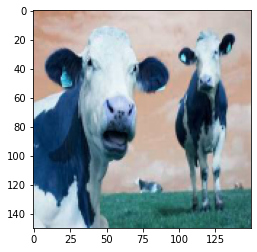

In [5]:
#image and label demostration
print('Label:', y_train[2])
plt.imshow(X_train[2])

# Pre-processing

In [6]:
#Rescale - needed for variables to lower variance and improve accuracy
X_train = X_train/255
X_val = X_val/255

In [7]:
# [0 1 0 0 0]:farfalla; [0 0 0 0 1]:scoiattolo, [1 0 0 0 0]:elefante, [0 0 1 0 0]:mucca, [0 0 0 1 0]:pecora
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
print(y_train[0], y_train[1], y_train[2], y_train[3], y_train[4])
y_train = lb.transform(y_train)
y_val = lb.transform(y_val)
print(y_train[0], y_train[1], y_train[2], y_train[3], y_train[4])

farfalla scoiattolo mucca scoiattolo elefante
[0 1 0 0 0] [0 0 0 0 1] [0 0 1 0 0] [0 0 0 0 1] [1 0 0 0 0]


In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True
)

In [ ]:
train_datagen.fit(X_train)

# VGG based CNN

In [8]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable=False
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 2,565
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
model.fit(
    X_train, y_train,
    epochs=10,
    steps_per_epoch=56,
    validation_steps=14,
    validation_data=(X_val, y_val)
)

Train on 5656 samples, validate on 1414 samples
Epoch 1/10
5656/5656 [==============================] - 1044s 185ms/sample - loss: 0.7777 - accuracy: 0.7314 - val_loss: 0.5048 - val_accuracy: 0.8430
Epoch 2/10
5656/5656 [==============================] - 1188s 210ms/sample - loss: 0.4384 - accuracy: 0.8623 - val_loss: 0.4246 - val_accuracy: 0.8579
Epoch 3/10
5656/5656 [==============================] - 1287s 227ms/sample - loss: 0.3703 - accuracy: 0.8792 - val_loss: 0.4058 - val_accuracy: 0.8678
Epoch 4/10
5656/5656 [==============================] - 1267s 224ms/sample - loss: 0.3385 - accuracy: 0.8879 - val_loss: 0.3769 - val_accuracy: 0.8727
Epoch 5/10
5656/5656 [==============================] - 1161s 205ms/sample - loss: 0.3147 - accuracy: 0.8967 - val_loss: 0.3688 - val_accuracy: 0.8692
Epoch 6/10
5656/5656 [==============================] - 1203s 213ms/sample - loss: 0.2967 - accuracy: 0.8999 - val_loss: 0.3544 - val_accuracy: 0.8706
Epoch 7/10
5656/5656 [========================

- The model overfits without reaching validation of at least 90%. Also model is too slow.

# Mobile Net 2

In [18]:
base_model = applications.MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights="imagenet",
    classes=5)
base_model.trainable=False
model1 = tf.keras.models.Sequential()
model1.add(base_model)
model1.add(tf.keras.layers.GlobalAveragePooling2D())
model1.add(tf.keras.layers.Dense(256, kernel_regularizer='l2', activation='relu'))
model1.add(tf.keras.layers.Dense(5, activation='softmax'))

In [19]:
model1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               327936    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 2,587,205
Trainable params: 329,221
Non-trainable params: 2,257,984
_________________________________________________________________


- Fitting the model. N of epochs: 10.

In [20]:
model1.fit(
    X_train, y_train,
    epochs=5,
    steps_per_epoch=56,
    validation_steps=14,
    validation_data=(X_val, y_val)
)

Train on 5656 samples, validate on 1414 samples
Epoch 1/5
5656/5656 [==============================] - 148s 26ms/sample - loss: 3.3958 - accuracy: 0.8066 - val_loss: 1.1014 - val_accuracy: 0.8741
Epoch 2/5
5656/5656 [==============================] - 151s 27ms/sample - loss: 0.7648 - accuracy: 0.8877 - val_loss: 0.7210 - val_accuracy: 0.8826
Epoch 3/5
5656/5656 [==============================] - 130s 23ms/sample - loss: 0.7068 - accuracy: 0.8883 - val_loss: 1.2373 - val_accuracy: 0.7885
Epoch 4/5
5656/5656 [==============================] - 141s 25ms/sample - loss: 0.6508 - accuracy: 0.8944 - val_loss: 1.1362 - val_accuracy: 0.8105
Epoch 5/5
5656/5656 [==============================] - 121s 21ms/sample - loss: 0.6771 - accuracy: 0.8906 - val_loss: 0.8622 - val_accuracy: 0.8798


In [22]:
model1.fit(
    X_train, y_train,
    epochs=4,
    steps_per_epoch=56,
    validation_steps=14,
    validation_data=(X_val, y_val)
)

Train on 5656 samples, validate on 1414 samples
Epoch 1/4
5656/5656 [==============================] - 145s 26ms/sample - loss: 0.5837 - accuracy: 0.9031 - val_loss: 0.8826 - val_accuracy: 0.8416
Epoch 2/4
5656/5656 [==============================] - 119s 21ms/sample - loss: 0.5774 - accuracy: 0.9045 - val_loss: 0.6420 - val_accuracy: 0.8932
Epoch 3/4
5656/5656 [==============================] - 123s 22ms/sample - loss: 0.5052 - accuracy: 0.9105 - val_loss: 1.1021 - val_accuracy: 0.8112
Epoch 4/4
5656/5656 [==============================] - 142s 25ms/sample - loss: 0.6530 - accuracy: 0.8950 - val_loss: 0.5847 - val_accuracy: 0.9187


## Target accuracy reached
- The Mobile Net 2 model with an extra layer of 256 layer size reaches 90%+ accuracy on validation set in 10 epochs. Performance is robust.

# Previous Attempts, CNN

In [ ]:
inputs1 = tf.keras.Input(shape=X_train[0].shape)
x1 = tf.keras.layers.Conv2D(input_shape=X_train[0].shape, filters=32, 
                kernel_size=(5,5), strides = (2,2), activation = 'relu')(inputs1)
x1 = tf.keras.layers.Dropout(0.2)(x1)
#x1 = tf.keras.layers.Conv2D(input_shape = (86,86,48), filters=32, kernel_size=(5,5), strides = (2,2), activation = 'relu')(x1)
#x1 = tf.keras.layers.Conv2D(input_shape = (42,42,32), filters=16, kernel_size=(5,5), strides = (2,2),  activation = 'relu')(x1)
#x1 = tf.keras.layers.Dropout(0.1)(x1)
x1 = tf.keras.layers.Flatten()(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.Dense(500, activation='relu')(x1)
outputs1 = tf.keras.layers.Dense(5,activation='softmax')(x1)

model1 = tf.keras.Model(inputs1, outputs1)
model1.summary()

Model: "functional_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 90, 90, 3)]       0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 43, 43, 32)        2432      
_________________________________________________________________
dropout_35 (Dropout)         (None, 43, 43, 32)        0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 59168)             0         
_________________________________________________________________
dense_70 (Dense)             (None, 500)               29584500  
_________________________________________________________________
dense_71 (Dense)             (None, 5)                 2505      
Total params: 29,589,437
Trainable params: 29,589,437
Non-trainable params: 0
_________________________________________

In [ ]:
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model1.fit(
    train_datagen.flow(X_train, y_train),
    batch_size = 512,
    epochs=20, 
    verbose = 2, 
    validation_data=(X_val, y_val)
)

Epoch 1/20
160/160 - 11s - loss: 1.2818 - accuracy: 0.4438 - val_loss: 1.0965 - val_accuracy: 0.5575
Epoch 2/20
160/160 - 10s - loss: 1.0971 - accuracy: 0.5607 - val_loss: 0.9292 - val_accuracy: 0.6435
Epoch 3/20
160/160 - 10s - loss: 1.0248 - accuracy: 0.5875 - val_loss: 1.0687 - val_accuracy: 0.5684
Epoch 4/20
160/160 - 10s - loss: 0.9764 - accuracy: 0.6128 - val_loss: 0.9892 - val_accuracy: 0.5973
Epoch 5/20
160/160 - 10s - loss: 0.9428 - accuracy: 0.6304 - val_loss: 0.7502 - val_accuracy: 0.7091
Epoch 6/20
160/160 - 10s - loss: 0.9060 - accuracy: 0.6440 - val_loss: 0.7377 - val_accuracy: 0.7201
Epoch 7/20
160/160 - 10s - loss: 0.8740 - accuracy: 0.6550 - val_loss: 0.7623 - val_accuracy: 0.7201
Epoch 8/20
160/160 - 10s - loss: 0.8679 - accuracy: 0.6550 - val_loss: 0.7855 - val_accuracy: 0.6990
Epoch 9/20
160/160 - 10s - loss: 0.8465 - accuracy: 0.6749 - val_loss: 0.9055 - val_accuracy: 0.6396
Epoch 10/20
160/160 - 10s - loss: 0.8244 - accuracy: 0.6841 - val_loss: 0.6911 - val_accura

# Test set

In [ ]:
#test set
X_test = []
files = glob.glob('animal_dataset_intermediate/test/*')
for f in files:
  try:
   img = cv2.imread(f)
   img = cv2.resize(img,(90,90))
   X_test.append(img)
  except:
    pass
#Test set rescale
X_test = np.array(X_test)/255
X_test.shape

In [ ]:
target = model.predict(X_test)
target = np.argmax(target, axis = 1)

In [ ]:
order = pd.read_csv('animal_dataset_intermediate/Testing_set_animals.csv', index_col = 'filename')
order.head()

,target
filename,
e030b20928e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg,NaN
e030b20929e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg,NaN
e030b2092be90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg,NaN
e030b2092ce90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg,NaN
e030b2092de90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg,NaN


In [ ]:
files = glob.glob('animal_dataset_intermediate/test/*')
new_files = []
for file in files:
  new_files.append(file[33:])

In [ ]:
new = np.concatenate([np.expand_dims(new_files, axis = 1), np.expand_dims(target, axis = 1)], axis = 1)

In [ ]:
complete_df = pd.DataFrame(new, columns= ['filename', 'target'])
complete_df = complete_df.set_index('filename')
complete_df.head()

,target
filename,
ea34b80920f1063ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg,1
e030b20a20e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg,1
OIP-3YmFQCmArKJnZxRqTprWPQHaFp.jpeg,4
e837b50f28f5003ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd_640.jpg,1
ea34b90b29fd073ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg,1


In [ ]:
for iter in range(910):
  order['target'].iloc[iter] = complete_df['target'].loc[(order.iloc[iter].name)]

In [ ]:
string_target = []

for k in order['target'].values:
  string_target.append(classes[int(k)])

In [ ]:
import pandas as pd
res = pd.DataFrame(string_target) 

# To download the csv file locally
from google.colab import files
res.to_csv('prediction_results.csv')